In [1]:
%matplotlib ipympl

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from generate_data import donut_dataset
torch.manual_seed(1337)
LAPTOP = True
if LAPTOP:
    device = torch.device("cpu")
else:
    device = torch.device("cuda:0")

samples, labels = donut_dataset(num_classes=2)
samples = torch.from_numpy(samples).float()
labels = torch.from_numpy(labels).float()
samples = (samples - samples.mean(axis=0)) / samples.std(axis=0)

samples = torch.Tensor(samples).to(device)
labels = torch.Tensor(labels).to(device)

x0 = samples.cpu()
xmin, xmax = x0[:, 0].min(), x0[:, 0].max()
ymin, ymax = x0[:, 1].min(), x0[:, 1].max()

xmin, xmax = -5, 5
ymin, ymax = -5, 5

r1 = r2 = 60
X, Y = np.meshgrid(np.linspace(xmin, xmax, r1), np.linspace(ymin, ymax, r2))
v = (
    torch.stack((torch.from_numpy(X.flatten()), torch.from_numpy(Y.flatten())), axis=1)
    .float()
    .to(device)
)

class SimpleNN(nn.Module):
    def __init__(self, activationFn):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Sequential(nn.Linear(2, 3), activationFn)
        self.fc2 = nn.Linear(3, 2)
        # self.actFn = activationFn

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return torch.nn.Softmax(dim=1)(x)


# Define a hook class
class FeatureExtractor:
    def __init__(self):
        self.activations = []

    def hook(self, module, input, output):
        # output is of shape (batch_size, num_neurons)
        # We transpose it to (num_neurons, batch_size) to separate neuron activations
        self.activations = output.detach().transpose(0, 1)
# Create an instance of the hook class
feature_extractor = FeatureExtractor()



In [2]:
torch.manual_seed(1337)
def train(model, data, target, optimizer, criterion, epochs=100):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(data).squeeze()
        loss = criterion(
            output, target.long()
        )
        preds = torch.argmax(output, dim=1)
        acc = torch.sum(preds == labels) / len(labels)
        num_wrong = (preds != labels).sum()
        loss.backward()
        optimizer.step()

    print(f"Accuracy: {acc:.2f}, Wrong: {num_wrong}")
    return model

Accuracy: 1.00, Wrong: 0
Sum of Logits adds to 1: True


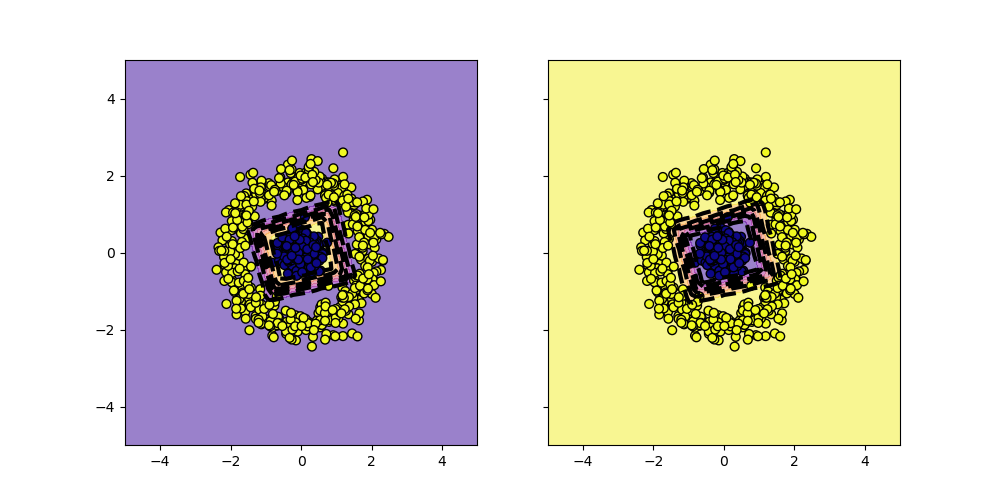

In [3]:
torch.manual_seed(1337)


model = SimpleNN(torch.nn.ReLU())
# Attach the hook to the first fully connected layer
hook = model.fc1.register_forward_hook(feature_extractor.hook)
optimizer = optim.AdamW(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

train(model, samples, labels, optimizer, criterion, epochs=400)

grid = model(v).detach().numpy()


fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
ax = ax.flatten()
ax0 = ax[0]
ax1 = ax[1]

g = grid[:, 0]
ax0.contourf(X, Y, g.reshape(r1, r2), alpha=0.5, cmap="plasma", vmin=0, vmax=1)
ax0.contour(X, Y, g.reshape(r1, r2), colors="k", linewidths=3, linestyles="dashed")
ax0.scatter(x0[:, 0], x0[:, 1], c=labels.cpu(), s=40, cmap="plasma", edgecolors="black")

g = grid[:, 1]
ax1.contourf(X, Y, g.reshape(r1, r2), alpha=0.5, cmap="plasma", vmin=0, vmax=1)
ax1.contour(X, Y, g.reshape(r1, r2), colors="k", linewidths=3, linestyles="dashed")
ax1.scatter(x0[:, 0], x0[:, 1], c=labels.cpu(), s=40, cmap="plasma", edgecolors="black")

print(
    f"Sum of Logits adds to 1: {torch.allclose(torch.from_numpy(grid.sum(axis=1)).float(), torch.tensor(1).float(), atol=1e-3)}"
)
plt.show()

(3, 3600)


Text(0.5, 1.0, 'Combined WITH Softmax')

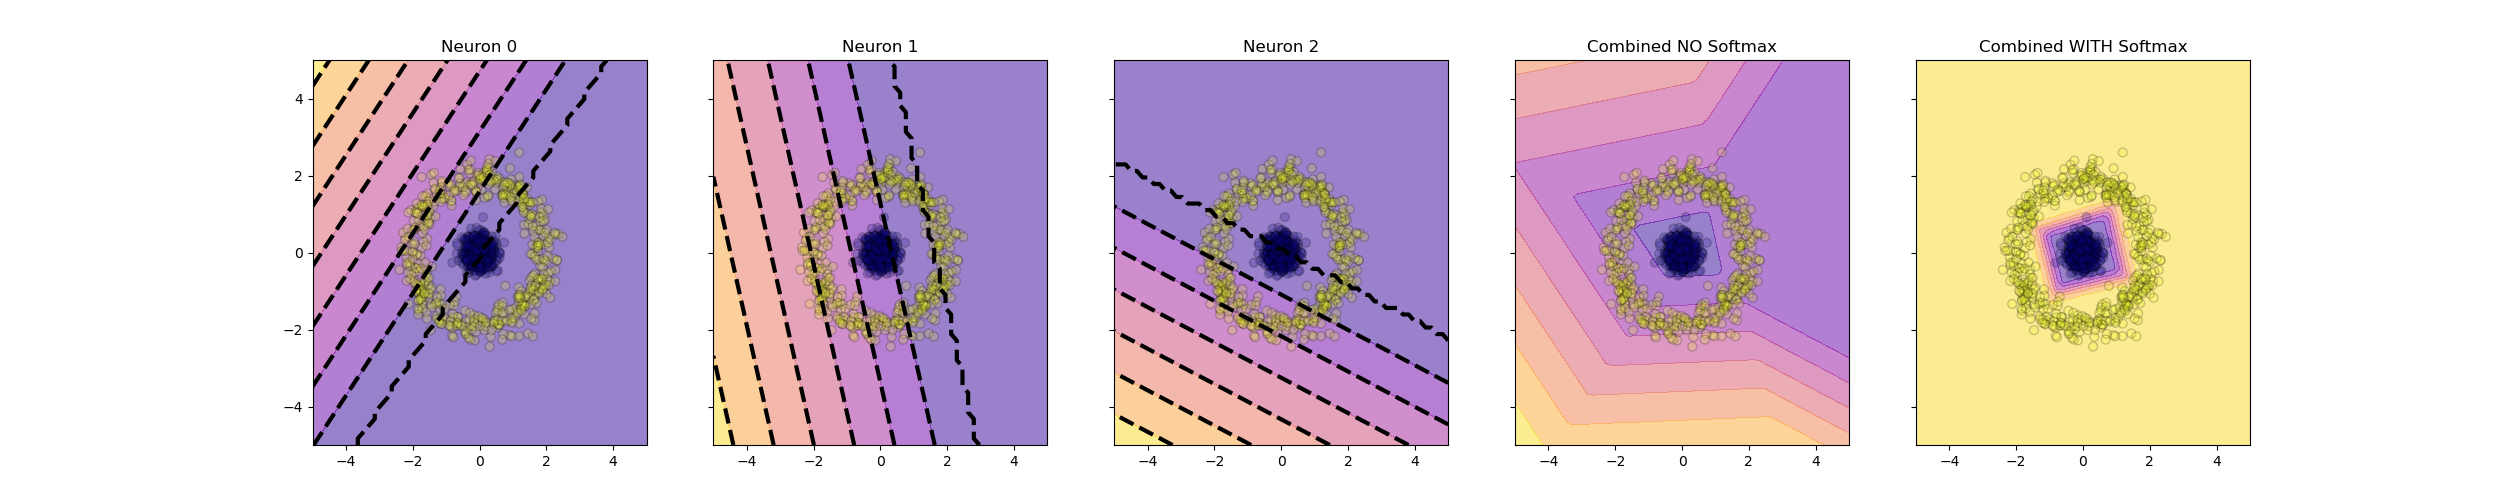

In [4]:
neuron_activations = (
    feature_extractor.activations
)  # List of tensor, each tensor is activations of a neuron
neuron_activations = neuron_activations.cpu().numpy()
print(neuron_activations.shape)


fig, ax = plt.subplots(1, 5, figsize=(25, 5), sharex=True, sharey=True)
ax = ax.flatten()
ax0 = ax[0]
ax1 = ax[1]
ax2 = ax[2]
ax3 = ax[3]
ax4 = ax[4]

g = neuron_activations[0]
ax0.contourf(X, Y, g.reshape(r1, r2), alpha=0.5, cmap="plasma")
ax0.contour(X, Y, g.reshape(r1, r2), colors="k", linewidths=3, linestyles="dashed")
ax0.scatter(
    x0[:, 0],
    x0[:, 1],
    c=labels.cpu(),
    s=40,
    cmap="plasma",
    edgecolors="black",
    alpha=0.2,
)
ax0.set_title("Neuron 0")

g = neuron_activations[1]
ax1.contourf(X, Y, g.reshape(r1, r2), alpha=0.5, cmap="plasma")
ax1.contour(X, Y, g.reshape(r1, r2), colors="k", linewidths=3, linestyles="dashed")
ax1.scatter(
    x0[:, 0],
    x0[:, 1],
    c=labels.cpu(),
    s=40,
    cmap="plasma",
    edgecolors="black",
    alpha=0.2,
)
ax1.set_title("Neuron 1")

g = neuron_activations[2]
ax2.contourf(X, Y, g.reshape(r1, r2), alpha=0.5, cmap="plasma")
ax2.contour(X, Y, g.reshape(r1, r2), colors="k", linewidths=3, linestyles="dashed")
ax2.scatter(
    x0[:, 0],
    x0[:, 1],
    c=labels.cpu(),
    s=40,
    cmap="plasma",
    edgecolors="black",
    alpha=0.2,
)
ax2.set_title("Neuron 2")


g = (
    torch.from_numpy(neuron_activations).T @ model.fc2.weight.data.T
    + model.fc2.bias.data
)[:, 1]

ax3.contourf(X, Y, g.reshape(r1, r2), alpha=0.5, cmap="plasma")
ax3.scatter(
    x0[:, 0],
    x0[:, 1],
    c=labels.cpu(),
    s=40,
    cmap="plasma",
    edgecolors="black",
    alpha=0.2,
)
ax3.set_title("Combined NO Softmax")

g = torch.nn.Softmax(dim=1)(
    torch.from_numpy(neuron_activations).T @ model.fc2.weight.data.T
    + model.fc2.bias.data
)[:, 1]

ax4.contourf(X, Y, g.reshape(r1, r2), alpha=0.5, cmap="plasma")
ax4.scatter(
    x0[:, 0],
    x0[:, 1],
    c=labels.cpu(),
    s=40,
    cmap="plasma",
    edgecolors="black",
    alpha=0.2,
)
ax4.set_title("Combined WITH Softmax")

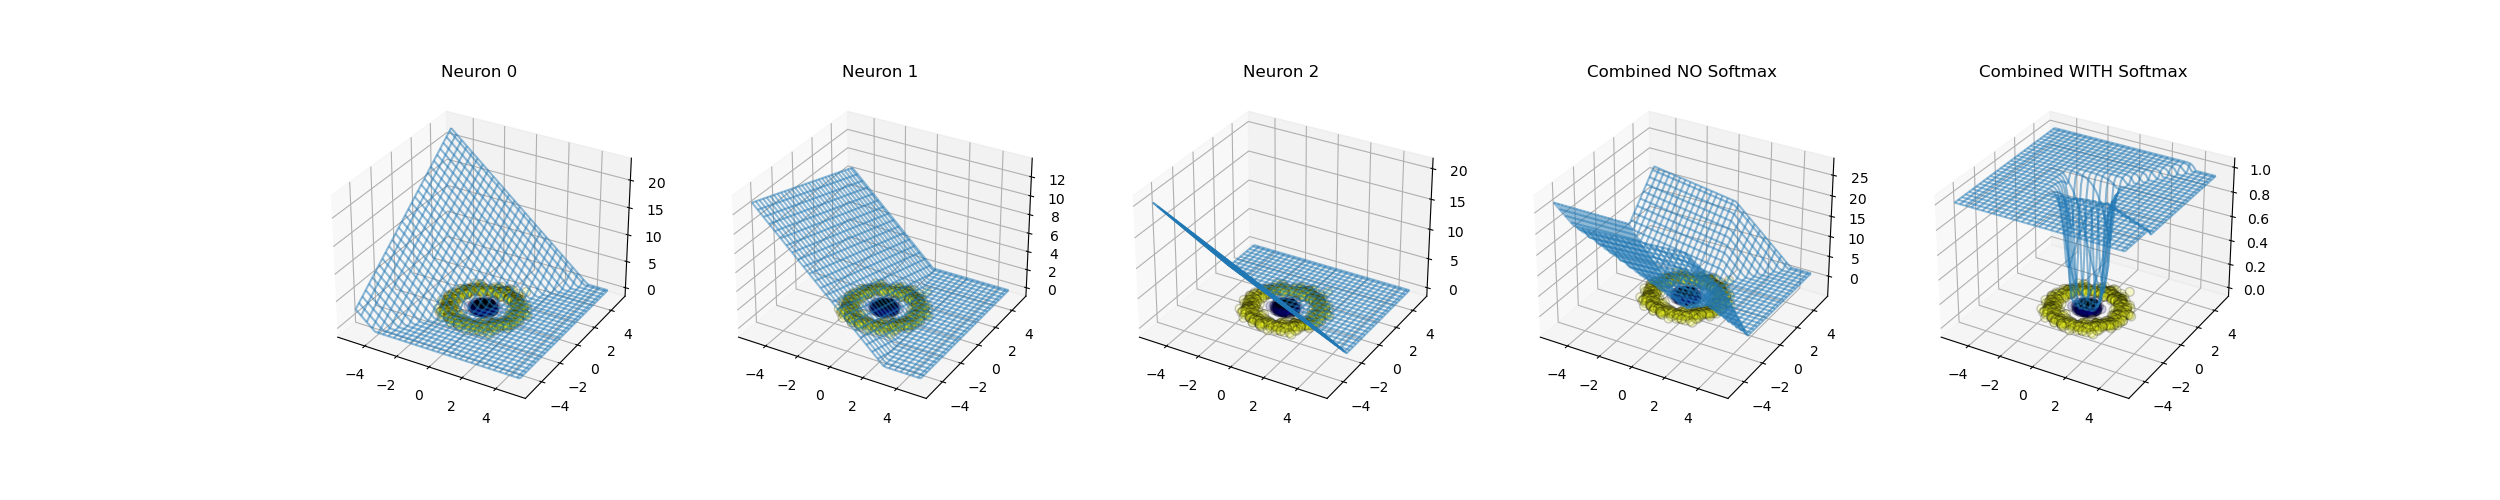

In [5]:
fig, ax = plt.subplots(2,3, figsize=(25, 5), subplot_kw={"projection": "3d"})
ax = ax.flatten()
ax0 = ax[0]
ax1 = ax[1]
ax2 = ax[2]
ax3 = ax[3]
ax4 = ax[4]

g = neuron_activations[0]
ax0.plot_wireframe(X, Y, g.reshape(r1, r2), alpha=0.5, cmap="plasma")

ax0.scatter(
    x0[:, 0],
    x0[:, 1],
    c=labels.cpu(),
    s=40,
    cmap="plasma",
    edgecolors="black",
    alpha=0.2,
)
ax0.set_title("Neuron 0")

g = neuron_activations[1]
ax1.plot_wireframe(X, Y, g.reshape(r1, r2), alpha=0.5, cmap="plasma")
ax1.scatter(
    x0[:, 0],
    x0[:, 1],
    c=labels.cpu(),
    s=40,
    cmap="plasma",
    edgecolors="black",
    alpha=0.2,
)
ax1.set_title("Neuron 1")

g = neuron_activations[2]
ax2.plot_wireframe(X, Y, g.reshape(r1, r2), alpha=0.5, cmap="plasma")
ax2.scatter(
    x0[:, 0],
    x0[:, 1],
    c=labels.cpu(),
    s=40,
    cmap="plasma",
    edgecolors="black",
    alpha=0.2,
)
ax2.set_title("Neuron 2")


g = (
    torch.from_numpy(neuron_activations).T @ model.fc2.weight.data.T
    + model.fc2.bias.data
)[:, 1]

ax3.plot_wireframe(X, Y, g.reshape(r1, r2), alpha=0.5, cmap="plasma")
ax3.scatter(
    x0[:, 0],
    x0[:, 1],
    c=labels.cpu(),
    s=40,
    cmap="plasma",
    edgecolors="black",
    alpha=0.2,
)
ax3.set_title("Combined NO Softmax")

g = torch.nn.Softmax(dim=1)(
    torch.from_numpy(neuron_activations).T @ model.fc2.weight.data.T
    + model.fc2.bias.data
)[:, 1]

ax4.plot_wireframe(X, Y, g.reshape(r1, r2), alpha=0.5, cmap="plasma")
ax4.scatter(
    x0[:, 0],
    x0[:, 1],
    c=labels.cpu(),
    s=40,
    cmap="plasma",
    edgecolors="black",
    alpha=0.2,
)
ax4.set_title("Combined WITH Softmax")
plt.show()